In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ahk3hr6j
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ahk3hr6j
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=f96fa9956460806bfb93c1fdf79982cebda391258cfb1afd902e2c1ba469fb72
  Stored in directory: /tmp/pip-ephem-wheel-cache-wia2gvjt/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [2]:
import torch
import clip
from PIL import Image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 170MiB/s]


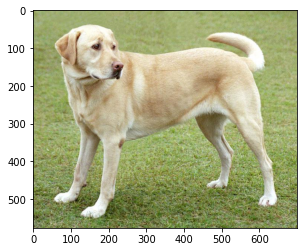

In [5]:
import matplotlib.pyplot as plt
plt.imshow(Image.open('CLIP.png'))

In [6]:
image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: probability of each token we provided!  cool isn't it !!
# you can give almost any object and it will give good scores for classification! 

Label probs: [[8.020e-04 9.971e-01 2.321e-03]]


In [14]:
## CIFAR-10 Benchmarking:
import os 
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy = 95.010


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished
<ipython-input-14-dc9cda255b4e>:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracy

In [15]:
# testing untrained logistic regression and using the emebdding matching only: 

test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /root/.cache
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7f5bfb300280>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )

In [45]:
dataiter = iter(test)
images, labels = next(dataiter)

In [46]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

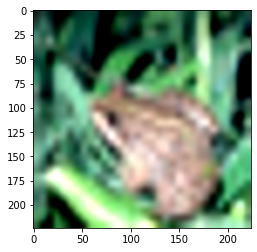

In [47]:
imshow(images)

6

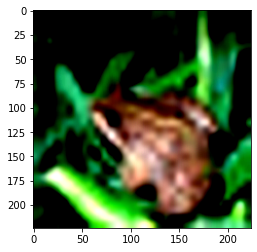

In [48]:
plt.imshow(images.permute(1,2,0))
labels

In [49]:
image = images.unsqueeze(0).to(device)
text = clip.tokenize(['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: probability of each token we provided!  cool isn't it !!

Label probs: [[1.153e-04 2.680e-04 3.878e-03 3.779e-04 2.558e-04 4.218e-04 9.941e-01
  7.677e-05 2.154e-04 2.611e-05]]


In [51]:
np.argmax(probs[0])

6

In [55]:
labels == np.argmax(probs[0])

True

In [63]:
text = clip.tokenize(['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']).to(device)
text_features = model.encode_text(text)

correct = 0
incorrect = 0
with torch.no_grad():
    for images, labels in tqdm(DataLoader(train, batch_size=1)):
        image_features = model.encode_image(image)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        pred = np.argmax(probs[0])
        if pred == int(labels): 
            correct += 1
        else:
            incorrect += 1
print(f'\nAccuracy: {(correct)/ (correct + incorrect)}')

100%|██████████| 50000/50000 [27:38<00:00, 30.15it/s]

Accuracy: 0.1


In [64]:
incorrect

45000

In [60]:
print(f'Accuracy: {(correct)/ (correct + incorrect)}')

Accuracy: 0.1


In [57]:
int(labels)

0